# Wine Price Prediction - Initial Data Exploration

## Data and Use case

[**Wine Reviews** - 130k wine reviews with variety, location, winery, price, and description](https://www.kaggle.com/zynicide/wine-reviews/home)

This dataset is available on Kaggle and contains around 130k of wine reviews. The data was scraped from [WineEnthusiast](http://www.winemag.com/?s=&drink_type=wine) on November 22nd, 2017.

I plan to use this dataset to develop a model that predicts wine price for specified set of parameters, like wine variety, region, desired quality. Such model, may be integrated into an application that runs on a mobile device to suggest price range during wine shopping without need to do online search.

In [1]:
import pandas as pd

df_data_1 = pd.read_csv('winemag-data-130k-v2.zip')
df_data_1.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Column descriptions:
- country - The country that the wine is from
- description - A few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.
- designation - The vineyard within the winery where the grapes that made the wine are from
- points - The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)
- price - The cost for a bottle of the wine
- province - The province or state that the wine is from
- region_1 - The wine growing area in a province or state (ie Napa)
- region_2 - Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank
- taster_name - Name of the person who tasted and reviewed the wine
- taster_twitter_handle - Twitter handle for the person who tasted and reviewed the wine
- title - The title of the wine review, which often contains the vintage if you're interested in extracting that feature
- variety - The type of grapes used to make the wine (ie Pinot Noir)
- winery - The winery that made the wine

## Initial Data Exploration

The most important reasons / steps for this phase are:

- Identify quality issues (e.g. missing values, wrong measurements, …)
- Assess feature quality – how relevant is a certain measurement (e.g. use correlation matrix)
- Get an idea on the value distribution of your data using statistical measures and visualizations

In [3]:
import matplotlib.pyplot as plt # Library to plot graphics
import numpy as np # To handle with matrices
import seaborn as sns # to build modern graphics

import warnings
warnings.filterwarnings('ignore')

Let's see data format, size, shape, and number of null values:

In [4]:
print(df_data_1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
Unnamed: 0               129971 non-null int64
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 13.9+ MB
None


### Null values

Let's check number of null values in each of the columns.

In [5]:
def checkMissingValues(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum() / df.isnull().count() * 100 ).sort_values(ascending = False)
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    print("Statistics for empty values in data:\n")
    print(df[~(df['Total'] == 0)])

In [6]:
checkMissingValues(df_data_1)

Statistics for empty values in data:

                       Total    Percent
region_2               79460  61.136715
designation            37465  28.825661
taster_twitter_handle  31213  24.015357
taster_name            26244  20.192197
region_1               21247  16.347493
price                   8996   6.921544
province                  63   0.048472
country                   63   0.048472
variety                    1   0.000769


We have 4 variables with the a relative high (20%+) number of nulls. At the same time, number of nulls looks quite good for the variables we consider as candidate features. The values is lower than 1% for country, province, and variety.

### Unique values

Now, let's print the unique values for all columns.

In [7]:
print("Statistics for nonunique values in data:\n")
print(df_data_1.nunique())

Statistics for nonunique values in data:

Unnamed: 0               129971
country                      43
description              119955
designation               37979
points                       21
price                       390
province                    425
region_1                   1229
region_2                     17
taster_name                  19
taster_twitter_handle        15
title                    118840
variety                     707
winery                    16757
dtype: int64


It's interesting that we have just 19 tasters and 21 unique point values; will need to look at the actual range for points.

### Duplicates

Let's look for duplicates in review descriptions, since even if other fields are different, it's quite unprobable to see the identical texts.

In [8]:
print("Number of desctiption duplicates:", df_data_1[df_data_1.duplicated('description',keep=False)].shape[0])

Number of desctiption duplicates: 20026


It seems, that there are quite a lot of duplicates in this data.

In [9]:
df_data_1[df_data_1.duplicated('description',keep=False)].sort_values('description').head(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
67614,67614,US,"100% Malbec, it's redolent with dark plums, wi...",NaN,87,20.0,Washington,Rattlesnake Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge
46540,46540,US,"100% Malbec, it's redolent with dark plums, wi...",NaN,87,20.0,Washington,Rattlesnake Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge
119702,119702,US,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,Rosé,Ross Andrew
72181,72181,US,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,Rosé,Ross Andrew
73731,73731,France,"87-89 Barrel sample. A pleasurable, perfumed w...",Barrel sample,88,NaN,Bordeaux,Saint-Julien,NaN,Roger Voss,@vossroger,Château Lalande-Borie 2008 Barrel sample (Sai...,Bordeaux-style Red Blend,Château Lalande-Borie


We will need to remove duplicates during ETL.

## Numerical fields
Let's start looking at two numerical feilds we have in the dataset: points and prices.

In [10]:
print("Statistics of numerical data:")
print(df_data_1[['points', 'price']].describe())

Statistics of numerical data:
              points          price
count  129971.000000  120975.000000
mean       88.447138      35.363389
std         3.039730      41.022218
min        80.000000       4.000000
25%        86.000000      17.000000
50%        88.000000      25.000000
75%        91.000000      42.000000
max       100.000000    3300.000000


As we can see the values of points are distributed between 80 and 100. The price have a high difference between the values and a high standard deviation.

Let's define some functions first.

In [11]:
def plotDistributions(df, column, label):
    plt.figure(figsize=(20,6))

    plt.subplot(1,2,1)
    g = sns.distplot(df[column], hist=True) 
    g.set_title(label + " Frequency Distribuition", fontsize=20)
    g.set_xlabel(label, fontsize=15)
    g.set_ylabel("Frequency", fontsize=15)

    plt.subplot(1,2,2)
    plt.scatter(range(df.shape[0]), np.sort(df[column].values))
    plt.xlabel("Index", fontsize=15)
    plt.ylabel(label, fontsize=15)
    plt.title(label + " Distribuition", fontsize=20)

    plt.show()

In [12]:
def printOutliers(df): 
    data_mean, data_std = np.mean(df), np.std(df)

    # seting the cut line to both higher and lower values
    cut = data_std * 3

    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df if x < lower]
    outliers_higher = [x for x in df if x > upper]
    outliers_total = [x for x in df if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df if x > lower and x < upper]
    
    print('Identified outliers lower boundary: %d' % lower)
    print('Identified outliers upper boundary: %d' % upper)
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Identified outliers: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

### Points

Let's start with points and look at distributions.

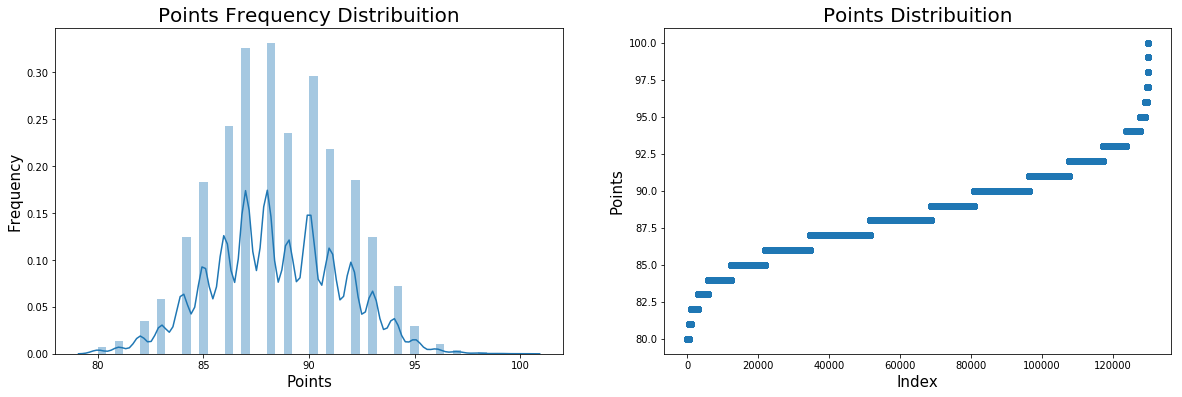

In [13]:
plotDistributions(df_data_1, 'points', 'Points')

We can see clear the distribuitioon of our data. Just a few number of wines have less than 82 points and more than 95 points. 

Let's check number of outlier points.

In [14]:
printOutliers(df_data_1['points'])

Identified outliers lower boundary: 79
Identified outliers upper boundary: 97
Identified lowest outliers: 0
Identified upper outliers: 129
Identified outliers: 129
Non-outlier observations: 129842
Total percentual of Outliers:  0.0994


All outliers for this field is in upper values: 129 wines have more than 98 points, which less than 0,01%.

##### Prices

Now, look at prices. We already saw that price have a high difference between the values and a high standard deviation. 75% of wines in our datset is cheaper than USD42, so let's look at wines that costs less than say USD150.

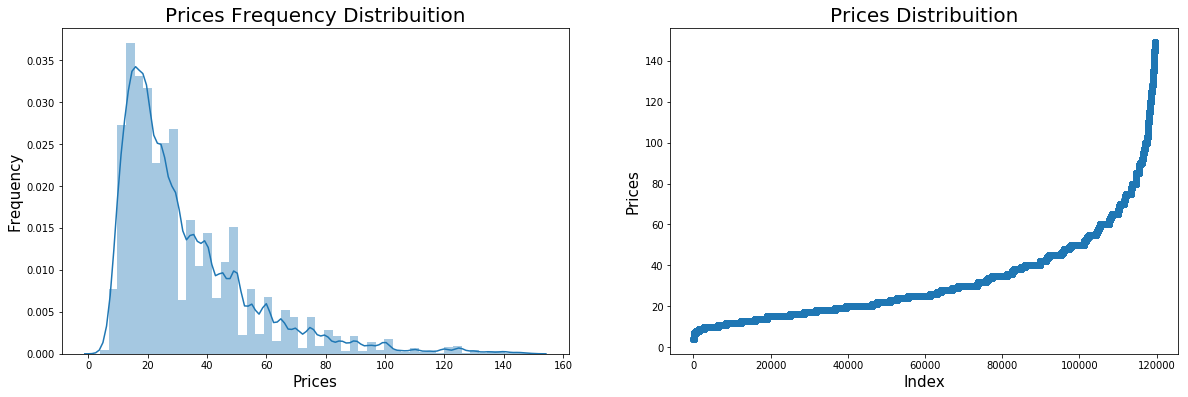

In [15]:
plotDistributions(df_data_1[df_data_1.price < 150], 'price', 'Prices')

We should have some outliers on price column, because on our 3 quartile the value is 42 and the values goes until 3300.

In [16]:
printOutliers(df_data_1['price'])

Identified outliers lower boundary: -87
Identified outliers upper boundary: 158
Identified lowest outliers: 0
Identified upper outliers: 1177
Identified outliers: 1177
Non-outlier observations: 119798
Total percentual of Outliers:  0.9825


Now we can clearly see that we have less than 1% of outliers, and 1177 prices are out of our range.

### Prices VS Points

Let's check if there is any correlation between our two numerical fields.

In [17]:
from scipy.stats import pearsonr

data = df_data_1[pd.notnull(df_data_1.price)]
data.shape

print("Pearson Correlation:", pearsonr(data.price, data.points))

Pearson Correlation: (0.41616674186062297, 0.0)


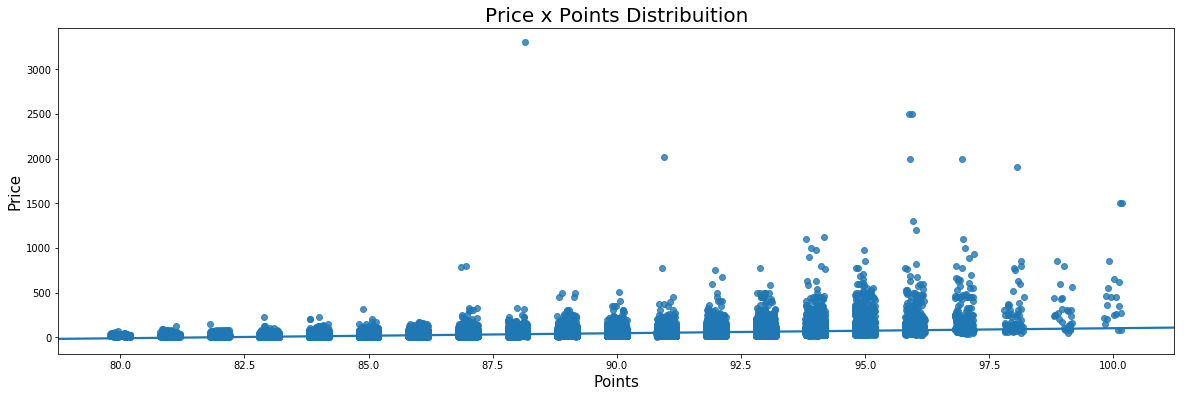

In [18]:
plt.figure(figsize=(20,6))

g = sns.regplot(y = 'price', x = 'points', data = df_data_1, x_jitter=.2)
g.set_title("Price x Points Distribuition", fontsize=20)
g.set_xlabel("Points", fontsize = 15)
g.set_ylabel("Price", fontsize = 15)

plt.show()

Not surprisingly, we can see significant correlation between the price of wine and its rating points. It's also interesting the highest prices are not for wines with highest points. The most expensive wine has around 88 points.

## Categorical fields

Let's look at some categorical fields in our dataset.

In [19]:
def plotDistributionsAndPrices(df, column, label, top):
    plt.figure(figsize=(20,6))

    counts = df[column].value_counts()[:top]

    g = sns.barplot(x=counts.index.values,y=counts.values)
    g.set_title("Top " + str(top) + " " + label + " Of Wine Origin", fontsize = 20)
    g.set_xlabel(label, fontsize=15)
    g.set_ylabel("Count", fontsize=15)
    g.set_xticklabels(g.get_xticklabels(), rotation = 90)

    plt.show()
    
    plt.figure(figsize=(20,6))
    g2 = sns.boxplot(x=column, y='price',
                  data=df.loc[(df[column].isin(counts.index.values))], showfliers=False)
    g2.set_title("Prices by " + label, fontsize=20)
    g2.set_xlabel(label, fontsize=15)
    g2.set_ylabel("Price USD", fontsize=15)
    g2.set_xticklabels(g.get_xticklabels(),rotation=90)

    plt.show()

### Country

Let's draw Top 20 Countries and price statistics without outliers.

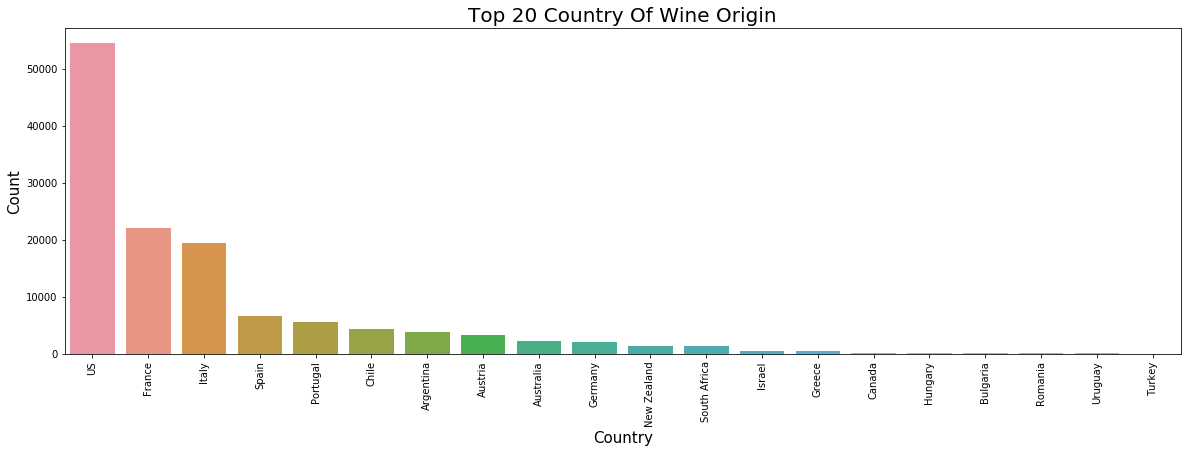

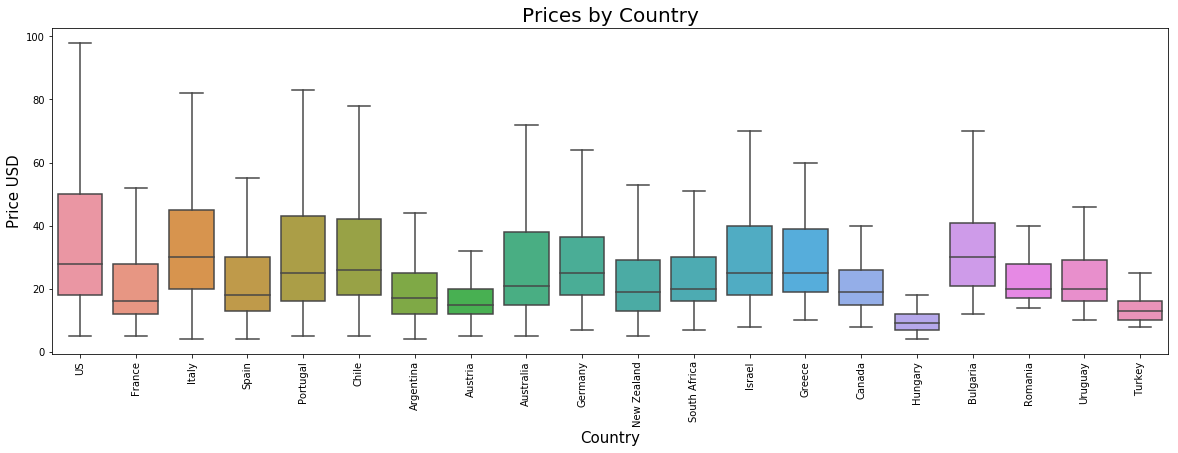

In [20]:
plotDistributionsAndPrices(df_data_1, 'country', 'Country', 20)

It's interesting to see US as the biggest wine productor in the dataset.

### Province

Let's draw Top 30 Provinces and price statistics without outliers.

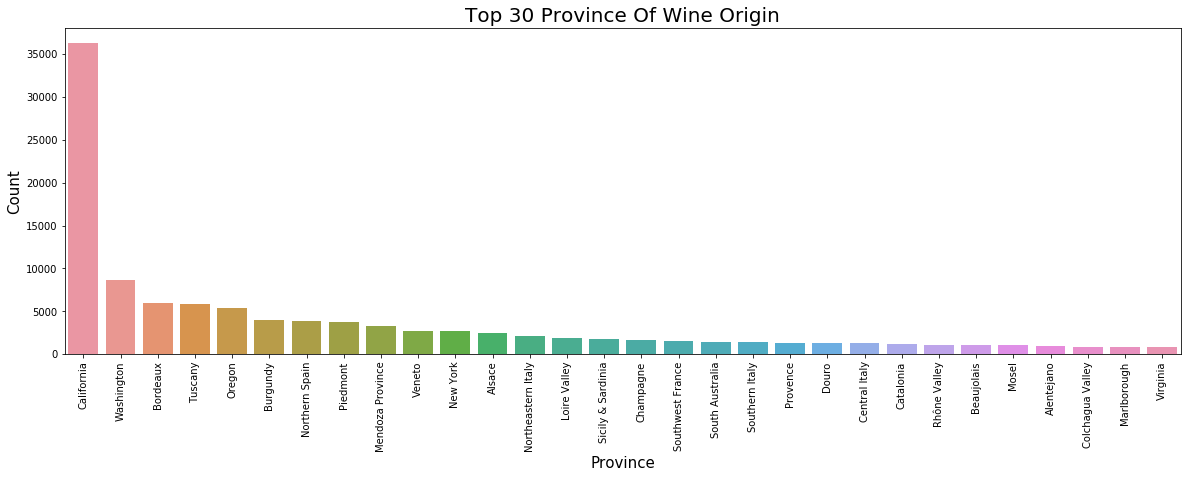

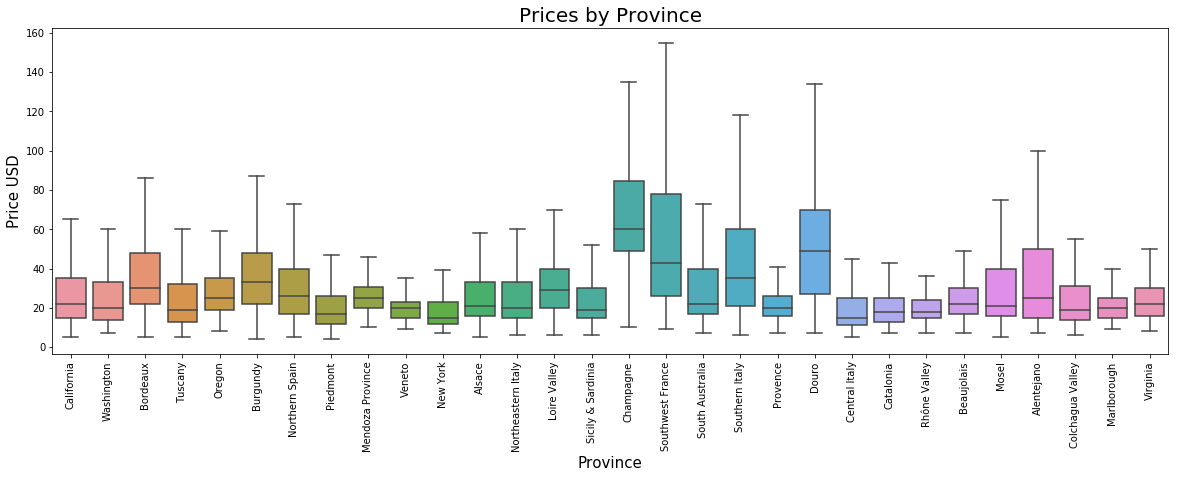

In [21]:
plotDistributionsAndPrices(df_data_1, 'province', 'Province', 30)

We can see good degree of price variation here.

### Variety

Let's draw Top 30 Varieties and price statistics without outliers.

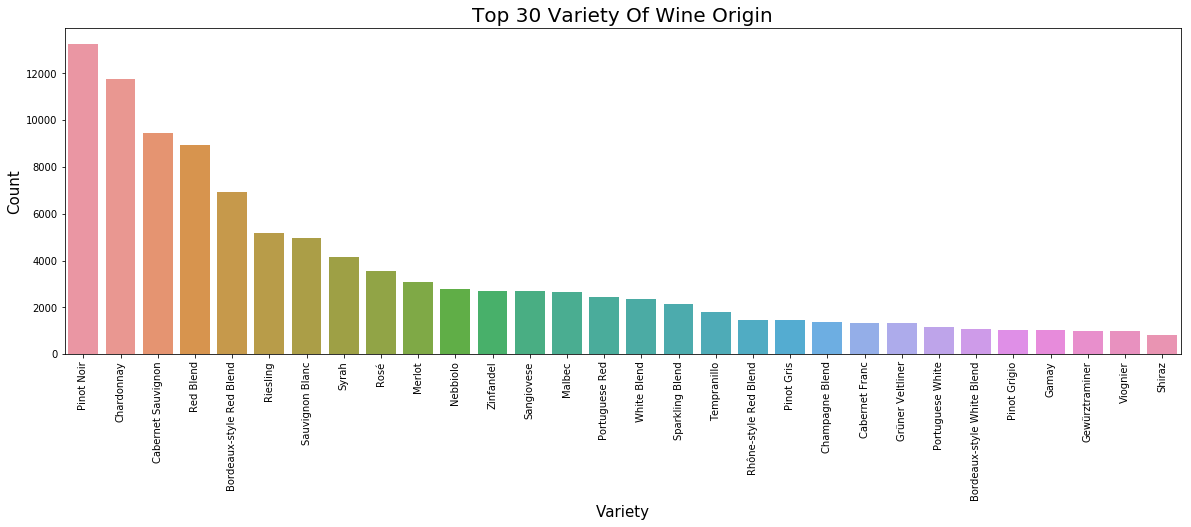

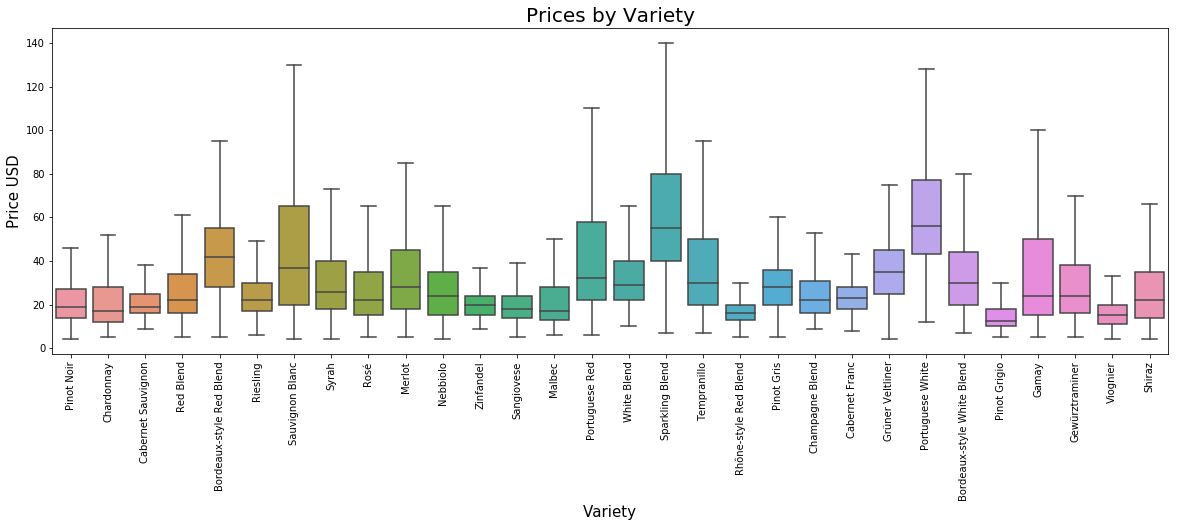

In [22]:
plotDistributionsAndPrices(df_data_1, 'variety', 'Variety', 30)

Again, we can see good degree of price variation per variety.

### Winery

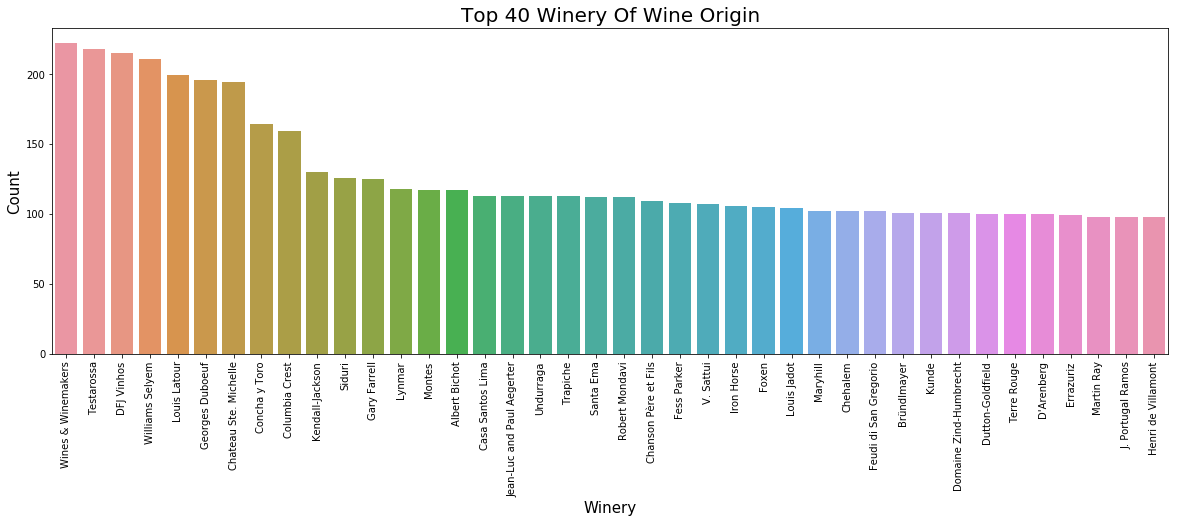

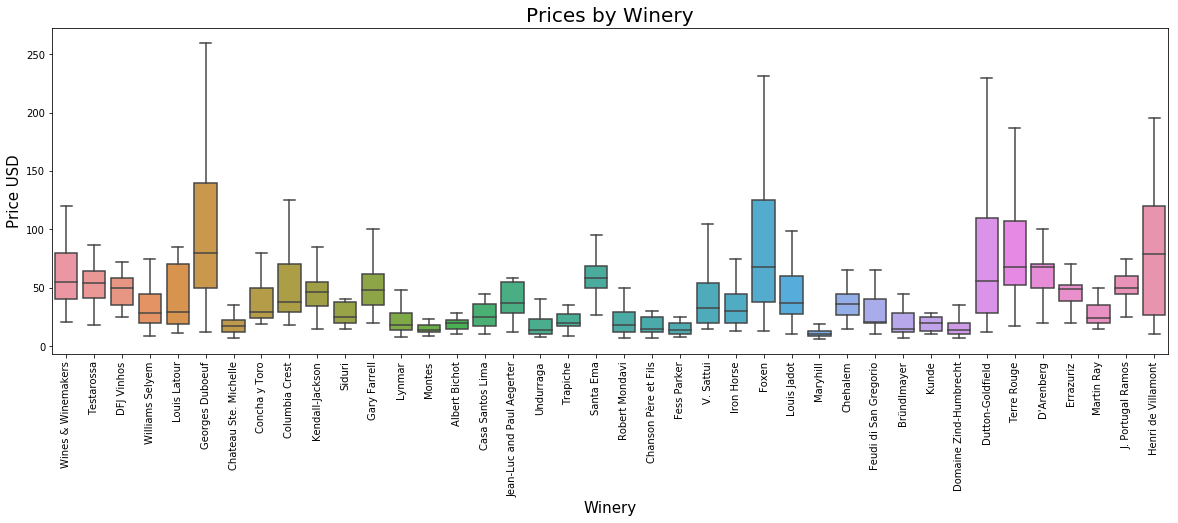

In [23]:
plotDistributionsAndPrices(df_data_1, 'winery', 'Winery', 40)

## Adding the vintage

The title of the wine review often contains the vintage. Let's check number of records that contain years 19xx-20xx in the title.

In [24]:
year_pattern = ".*(19[0-9]{2}|20[0-9]{2})"

print("Total number of records:", df_data_1.shape[0])
print("Number of records that contain a year:", df_data_1.title.str.contains(year_pattern).sum())

Total number of records: 129971
Number of records that contain a year: 125345


Looks like we managed to extract the vintage for quite big part of the records. Let's check what was extracted for the first rows in the dataset.

In [25]:
test = df_data_1[['title']].head(5)
test = test.assign(year=test.title.str.extract(year_pattern))
test

,title,year
0,Nicosia 2013 Vulkà Bianco (Etna),2013
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),2011
2,Rainstorm 2013 Pinot Gris (Willamette Valley),2013
3,St. Julian 2013 Reserve Late Harvest Riesling ...,2013
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,2012


Let's try to process the whole dataset and see some statistics on the vintage.

In [26]:
test = df_data_1[['title', 'price']]
test = test.assign(year=test.title.str.extract(year_pattern))

test = test[pd.notnull(test.year)]
print(test['year'].astype(int).describe())

count    125345.000000
mean       2010.637983
std           4.161448
min        1903.000000
25%        2009.000000
50%        2011.000000
75%        2013.000000
max        2067.000000
Name: year, dtype: float64


Values distribution and the maximal value look quite logical. Let's check the lower bound.

In [27]:
test[test.year < "1950"].head(5)

,title,price,year
1512,Pascal Aufranc 2011 Vignes de 1939 (Chénas),35.0,1939
3044,Pascal Aufranc 2015 En Rémont Vignes de 1939 ...,22.0,1939
8407,Kirsten 2013 1904 Spätlese Riesling (Mosel),50.0,1904
9808,Casella 2007 1919 Shiraz (Wrattonbully),100.0,1919
10494,Domaine de la Tour Boisée 2006 Plantation 1905...,13.0,1905


It seems, that we need to define more complex procedure to extract the vintage during ETL. Beside this, it looks quite promising.

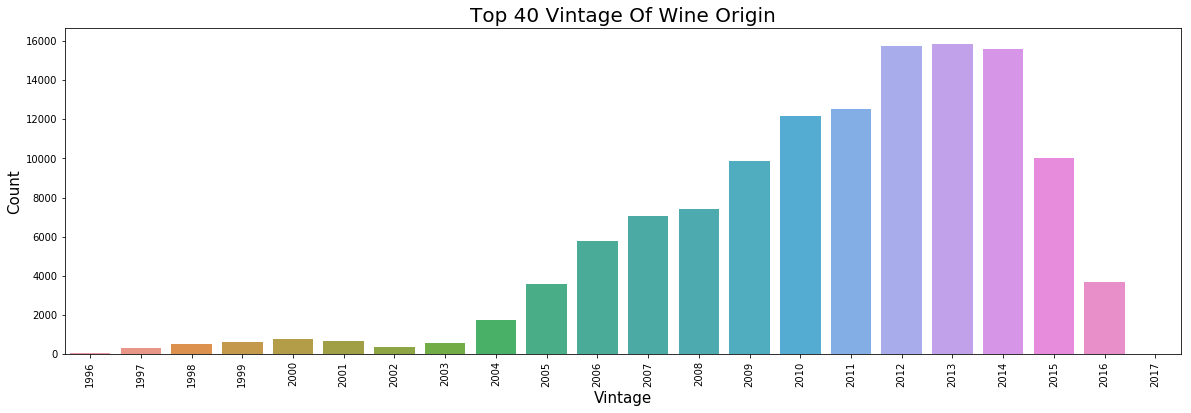

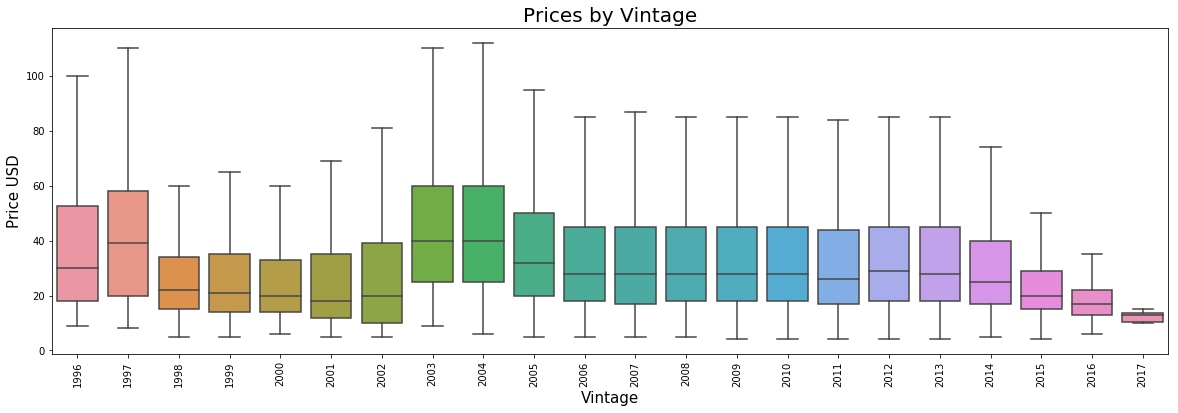

In [28]:
plotDistributionsAndPrices(test[(test.year > "1995") & (test.year < "2018")], 'year', 'Vintage', 40)

 Obviously, the vintage affects the price. However, there is no strong correlation. Need to try the year as a categorical value.